# Sampling Strategy Analysis for FIW Dataset

This notebook analyzes the sampling behavior of the KinshipBatchSampler with the FIWFamilyV3 dataset.

## Setup and Imports

In [1]:
# Enable autoreload
%load_ext autoreload
%autoreload 2

In [2]:
import sys
from collections import Counter, defaultdict
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns
from IPython.display import display
from tqdm.auto import tqdm

# Add the parent directory to path
sys.path.append(str(Path.cwd().parent))

from datasets.scl import SCLDataModule  # noqa

## Load Dataset

In [3]:
# Initialize dataset
dm = SCLDataModule(
    dataset="ff-v3", batch_size=64, root_dir="../data/fiw/track1", sampler_verbose=True  # Adjust path as needed
)
dm.setup("fit")

# Get the dataset and sampler
dataset = dm.train_dataset
sampler = dm.train_dataloader().batch_sampler

Loading samples from txt/train_sort_A2_m.txt
Loaded 107185 samples from txt/train_sort_A2_m.txt
Found 571 unique fids
Generated 4777 relationships
Found 2925 unique persons
Found 15310 unique images
Loading samples from txt/val_choose_A.txt
Loaded 4988 samples from txt/val_choose_A.txt
Setup fit datasets


## Initial Dataset Statistics

In [4]:
# Count unique individuals
n_individuals = len(dataset.people)
print(f"Number of unique individuals: {n_individuals}")

# Count relationships per family
relationships_per_family = {fid: len(rel_indices) for fid, rel_indices in dataset.fam2rel.items()}
print(f"\nNumber of families: {len(relationships_per_family)}")
print(f"Average relationships per family: {sum(relationships_per_family.values()) / len(relationships_per_family):.2f}")

# Count relationship types
relationship_types = Counter(labels[4] for _, _, labels in dataset.relationships)
print("\nRelationship type distribution:")
for rel_type, count in relationship_types.items():
    print(f"{rel_type}: {count}")

Number of unique individuals: 2925

Number of families: 571
Average relationships per family: 8.37

Relationship type distribution:
fs: 715
sibs: 686
md: 726
ms: 710
ss: 396
fd: 701
bb: 361
gmgd: 120
gfgd: 112
gmgs: 136
gfgs: 114


## Detailed Dataset Statistics

The co-occurrence matrix shows how frequently different relationship types appear together within the same family.
Here's how to interpret it:

1. **Basic Structure**:
- Each cell (i,j) shows how many families contain BOTH relationship type i AND relationship type j
- The diagonal (i,i) shows how many families have that relationship type at all
- The matrix is symmetric because co-occurrence is bidirectional

2. **Common Relationship Types**:
```
bb = brother-brother
ss = sister-sister
sibs = brother-sister
fs = father-son
fd = father-daughter
ms = mother-son
md = mother-daughter
gfgd = grandfather-granddaughter
gmgd = grandmother-granddaughter
gfgs = grandfather-grandson
gmgs = grandmother-grandson
```

3. **Expected Patterns**:
- Parent-child relationships (fs, fd, ms, md) should commonly co-occur because
  families typically have multiple children
- Sibling relationships (bb, ss, sibs) should also frequently appear together
- Grandparent relationships might be less common overall

This analysis will help identify:

1. **Imbalanced Relationships**
  - If some relationship types are significantly over/under-represented

2. **Gender Biases**:
  - By comparing ratios of similar relationships across genders (e.g., father-son vs father-daughter)

3. **Missing Expected Patterns**:
  - For example, if families with fathers rarely have both sons and daughters

4. **Unusual Clusters**:
  - If certain relationship types co-occur more frequently than expected

5. **Data Quality Issues**:
  - Very low co-occurrence between naturally related relationships might indicate data collection problems

The analysis prints:
- Frequency of each relationship type
- Strongest co-occurrences (normalized by individual frequencies)
- Unexpected absences of common family patterns
- Gender balance metrics

This can help identify both dataset biases and potential data quality issues
that might affect your model's performance.

In [5]:
def compute_relationship_cooccurrence(dataset, rel_types_per_family):
    """Compute co-occurrence matrix of relationship types across families.

    Args:
        dataset: The dataset containing relationships
        rel_types_per_family: Dict mapping family IDs to their relationship
            type counts

    Returns:
        tuple: (relationship types list, co-occurrence matrix)
    """
    rel_types = list(set(labels[4] for _, _, labels in dataset.relationships))
    cooccurrence = np.zeros((len(rel_types), len(rel_types)))

    for types in rel_types_per_family.values():
        present_types = list(types.keys())
        for i, type1 in enumerate(rel_types):
            for j, type2 in enumerate(rel_types):
                if type1 in present_types and type2 in present_types:
                    cooccurrence[i, j] += 1

    return rel_types, cooccurrence


def compute_family_relationships(dataset):
    """Compute relationship counts and types per family.

    Args:
        dataset: The dataset containing relationships

    Returns:
        tuple: (rel_per_family dict mapping family ID to relationship count,
                rel_types_per_family dict mapping family ID to relationship type counts)
    """
    rel_per_family = {fid: len(rel_indices) for fid, rel_indices in dataset.fam2rel.items()}

    rel_types_per_family = defaultdict(lambda: defaultdict(int))
    for fid, rel_indices in dataset.fam2rel.items():
        for idx in rel_indices:
            rel_type = dataset.relationships[idx][2][4]  # Get relationship type
            rel_types_per_family[fid][rel_type] += 1

    return rel_per_family, rel_types_per_family


def analyze_dataset_structure(dataset):
    # Relationship distribution per family
    rel_per_family, rel_types_per_family = compute_family_relationships(dataset)

    # Calculate statistics
    print("=== Family Statistics ===")
    n_rels = np.array(list(rel_per_family.values()))
    print("\nRelationships per family:")
    print(f"Mean: {n_rels.mean():.2f}")
    print(f"Median: {np.median(n_rels):.2f}")
    print(f"Std: {n_rels.std():.2f}")
    print(f"Skewness: {stats.skew(n_rels):.2f}")
    print(f"Kurtosis: {stats.kurtosis(n_rels):.2f}")
    print(f"Min: {n_rels.min()}")
    print(f"Max: {n_rels.max()}")

    # Visualize relationship distribution
    plt.figure(figsize=(10, 6))
    sns.histplot(n_rels, bins=50)
    plt.title("Distribution of Relationships per Family")
    plt.xlabel("Number of Relationships")
    plt.ylabel("Number of Families")
    plt.show()

    # Relationship type diversity per family
    rel_type_diversity = [len(types) for types in rel_types_per_family.values()]
    print("\n=== Relationship Type Diversity ===")
    print(f"Average number of different relationship types per family: {np.mean(rel_type_diversity):.2f}")
    print(f"Median number of different relationship types per family: {np.median(rel_type_diversity):.2f}")

    # Visualize relationship type diversity
    plt.figure(figsize=(10, 6))
    sns.histplot(rel_type_diversity, bins=range(min(rel_type_diversity), max(rel_type_diversity) + 2))
    plt.title("Distribution of Relationship Type Diversity per Family")
    plt.xlabel("Number of Different Relationship Types")
    plt.ylabel("Number of Families")
    plt.show()

    # Analyze co-occurrence of relationship types
    print("\n=== Relationship Type Co-occurrence ===")

    rel_types, cooccurrence = compute_relationship_cooccurrence(dataset, rel_types_per_family)

    # Plot co-occurrence heatmap
    plt.figure(figsize=(12, 10))
    sns.heatmap(cooccurrence, xticklabels=rel_types, yticklabels=rel_types, annot=True, fmt="g", cmap="YlOrRd")
    plt.title("Relationship Type Co-occurrence Matrix")
    plt.tight_layout()
    plt.show()

    # People per family statistics
    people_per_family = defaultdict(set)
    for rel_idx, rel in enumerate(dataset.relationships):
        fid = rel[2][2]  # Family ID
        mid1, mid2 = rel[2][:2]  # Member IDs
        people_per_family[fid].add(mid1)
        people_per_family[fid].add(mid2)

    n_people = np.array([len(members) for members in people_per_family.values()])
    print("\n=== People per Family Statistics ===")
    print(f"Mean: {n_people.mean():.2f}")
    print(f"Median: {np.median(n_people):.2f}")
    print(f"Std: {n_people.std():.2f}")
    print(f"Min: {n_people.min()}")
    print(f"Max: {n_people.max()}")

    # Visualize people per family distribution
    plt.figure(figsize=(10, 6))
    sns.histplot(n_people, bins=30)
    plt.title("Distribution of People per Family")
    plt.xlabel("Number of People")
    plt.ylabel("Number of Families")
    plt.show()

Analyzing dataset structure...
=== Family Statistics ===

Relationships per family:
Mean: 8.37
Median: 6.00
Std: 7.26
Skewness: 2.60
Kurtosis: 10.31
Min: 1
Max: 57


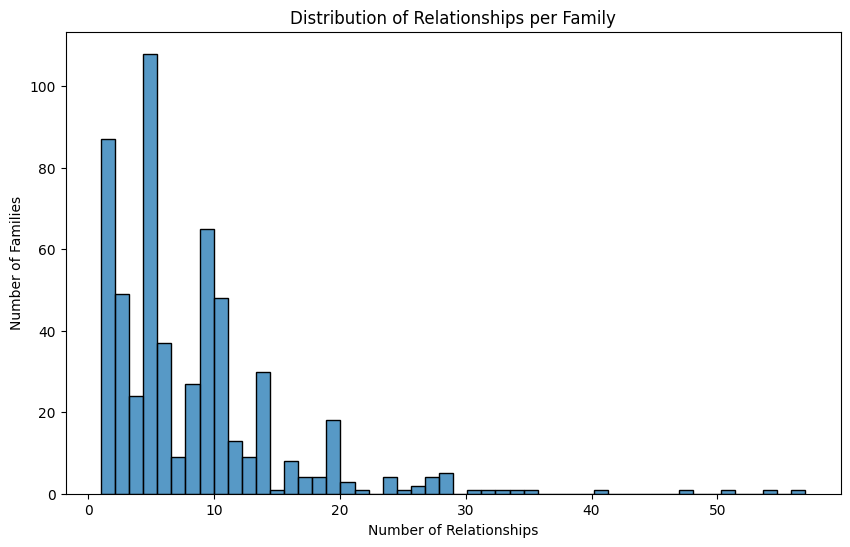


=== Relationship Type Diversity ===
Average number of different relationship types per family: 4.54
Median number of different relationship types per family: 5.00


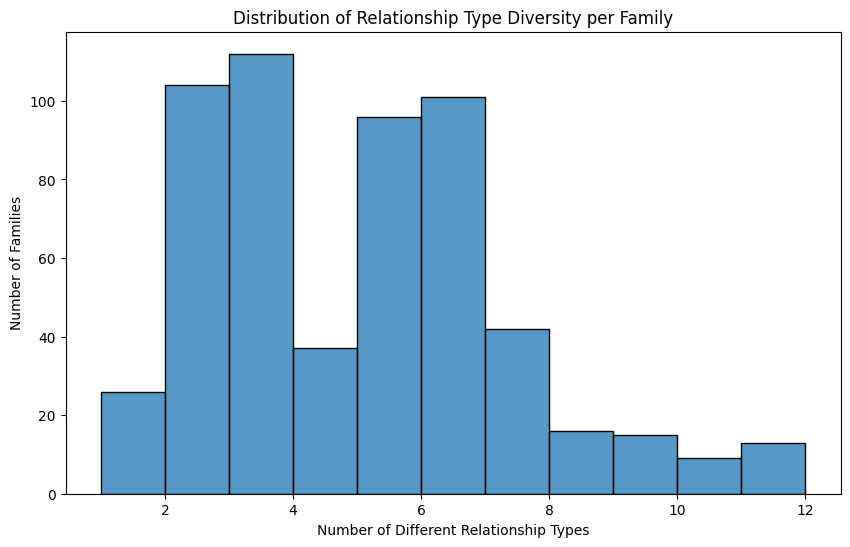


=== Relationship Type Co-occurrence ===


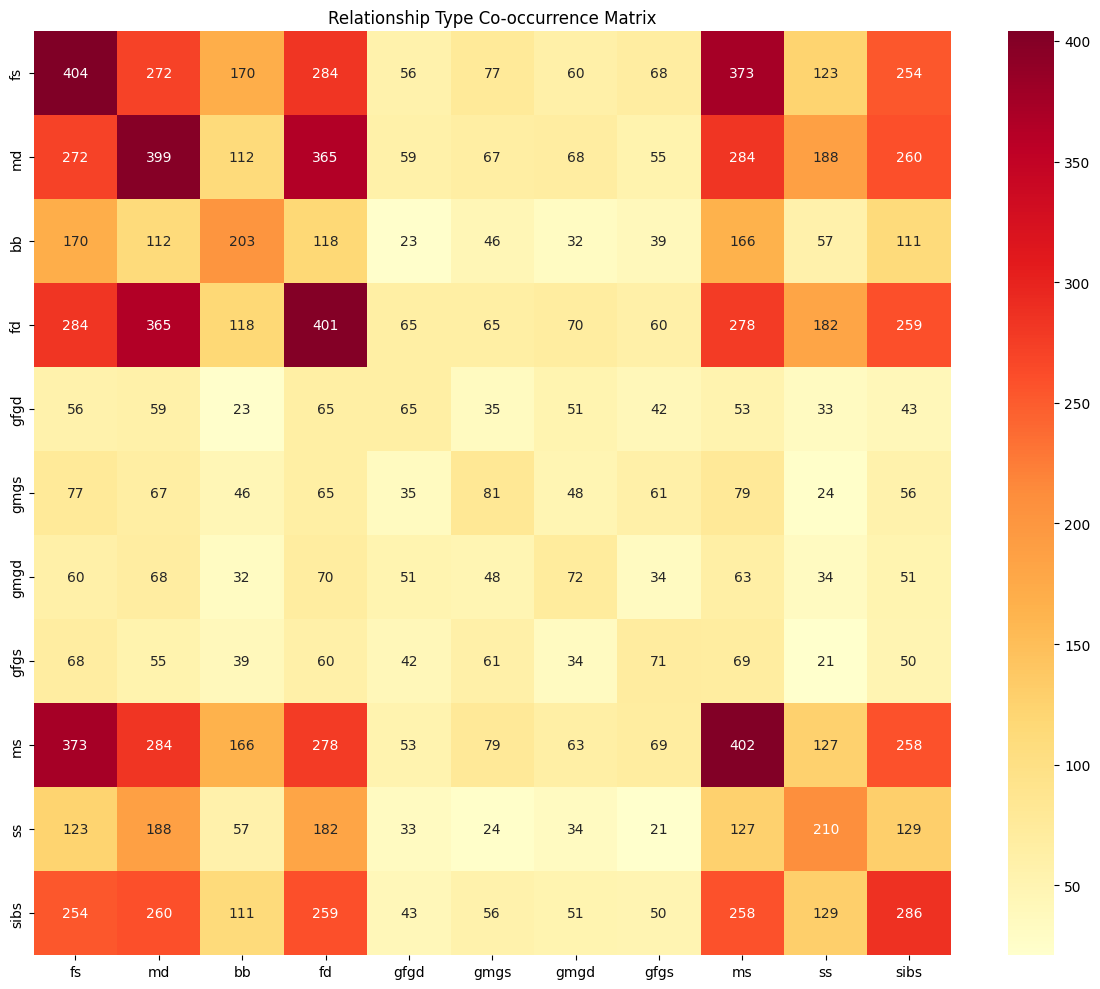


=== People per Family Statistics ===
Mean: 5.12
Median: 5.00
Std: 2.28
Min: 2
Max: 23


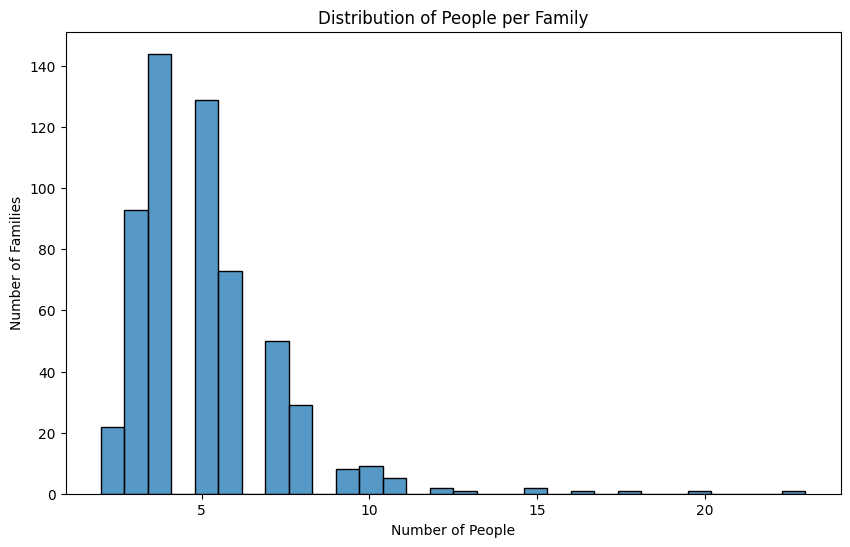

In [6]:
# Run the analysis
print("Analyzing dataset structure...")
analyze_dataset_structure(dataset)

In [7]:
def analyze_cooccurrence_patterns(cooccurrence, rel_types):
    total_families = cooccurrence.max()  # Assuming diagonal has highest values

    print("=== Co-occurrence Analysis ===")

    # Analyze diagonal (relationship frequency)
    print("\nRelationship Frequency (% of families):")
    for i, rel_type in enumerate(rel_types):
        percentage = (cooccurrence[i, i] / total_families) * 100
        print(f"{rel_type}: {percentage:.1f}%")

    # Find strongest co-occurrences
    print("\nStrongest Co-occurrences:")
    pairs = []
    for i in range(len(rel_types)):
        for j in range(i + 1, len(rel_types)):  # Upper triangle only
            if i != j:  # Skip diagonal
                strength = cooccurrence[i, j] / min(cooccurrence[i, i], cooccurrence[j, j])
                pairs.append((rel_types[i], rel_types[j], strength))

    # Sort by strength and print top 5
    pairs.sort(key=lambda x: x[2], reverse=True)
    for rel1, rel2, strength in pairs[:5]:
        print(f"{rel1}-{rel2}: {strength:.2f}")

    # Find unusual absences
    print("\nUnusual Absences (expected co-occurrences that are rare):")
    expected_pairs = [
        ("fs", "fd"),  # Fathers usually have both sons and daughters
        ("ms", "md"),  # Mothers usually have both sons and daughters
        ("bb", "sibs"),  # Brothers usually have sisters
        ("ss", "sibs"),  # Sisters usually have brothers
    ]

    for rel1, rel2 in expected_pairs:
        i, j = rel_types.index(rel1), rel_types.index(rel2)
        ratio = cooccurrence[i, j] / min(cooccurrence[i, i], cooccurrence[j, j])
        if ratio < 0.5:  # Arbitrary threshold
            print(f"{rel1}-{rel2}: {ratio:.2f}")

    # Check for gender imbalances
    print("\nGender Balance Analysis:")
    gender_pairs = [
        (("fs", "fd"), "father-child"),
        (("ms", "md"), "mother-child"),
        (("bb", "ss"), "siblings"),
        (("gfgs", "gfgd"), "grandfather-grandchild"),
        (("gmgs", "gmgd"), "grandmother-grandchild"),
    ]

    for (rel1, rel2), relation_type in gender_pairs:
        i, j = rel_types.index(rel1), rel_types.index(rel2)
        ratio = cooccurrence[i, i] / cooccurrence[j, j]
        print(f"{relation_type}: {ratio:.2f} ({rel1}/{rel2})")

In [8]:
rel_per_family, rel_types_per_family = compute_family_relationships(dataset)
rel_types, cooccurrence = compute_relationship_cooccurrence(dataset, rel_types_per_family)
analyze_cooccurrence_patterns(cooccurrence, rel_types)

=== Co-occurrence Analysis ===

Relationship Frequency (% of families):
fs: 100.0%
md: 98.8%
bb: 50.2%
fd: 99.3%
gfgd: 16.1%
gmgs: 20.0%
gmgd: 17.8%
gfgs: 17.6%
ms: 99.5%
ss: 52.0%
sibs: 70.8%

Strongest Co-occurrences:
fd-gfgd: 1.00
gmgs-ms: 0.98
fd-gmgd: 0.97
gfgs-ms: 0.97
fs-gfgs: 0.96

Unusual Absences (expected co-occurrences that are rare):

Gender Balance Analysis:
father-child: 1.01 (fs/fd)
mother-child: 1.01 (ms/md)
siblings: 0.97 (bb/ss)
grandfather-grandchild: 1.09 (gfgs/gfgd)
grandmother-grandchild: 1.12 (gmgs/gmgd)


## Sampling Analysis

Let's analyze how the sampler selects individuals and relationships over one epoch.

In [9]:
def analyze_epoch_sampling(sampler):
    # Counters for tracking
    individual_counts = Counter()
    relationship_type_counts = Counter()
    family_counts = Counter()

    # Iterate through one epoch
    for batch in tqdm(sampler, desc="Analyzing batches"):
        # Each batch is a list of tuples (img1_id, img2_id, labels)
        for item in batch[0]:
            img1_id, img2_id, labels = item
            # Track individuals
            individual_counts[img1_id] += 1
            individual_counts[img2_id] += 1

            # Track relationship types (labels[4] is kin_relation)
            relationship_type_counts[labels[4]] += 1

            # Track families (labels[2] is family ID)
            family_counts[labels[2]] += 1

    return individual_counts, relationship_type_counts, family_counts

## Visualization of Results

In [10]:
def visualize_sampling_results(individual_counts, relationship_type_counts, family_counts, title_prefix=""):
    """Plot distributions for individuals, relationships, and families."""
    # Individual sampling distribution
    plt.figure(figsize=(12, 6))
    plt.hist(list(individual_counts.values()), bins=50)
    plt.title(f"{title_prefix}Distribution of Individual Sampling Frequencies")
    plt.xlabel("Times Sampled")
    plt.ylabel("Number of Individuals")
    plt.show()

    # Relationship type distribution with specified order
    plt.figure(figsize=(12, 6))
    ordered_rel_types = ["bb", "ss", "sibs", "fs", "fd", "ms", "md", "gfgd", "gmgd", "gfgs", "gmgs"]
    rel_counts = [relationship_type_counts.get(rel, 0) for rel in ordered_rel_types]
    plt.bar(ordered_rel_types, rel_counts)
    plt.title(f"{title_prefix}Distribution of Relationship Types in Sampled Pairs")
    plt.xticks(rotation=45)
    plt.ylabel("Number of Samples")
    plt.tight_layout()
    plt.show()

    # Family sampling distribution
    plt.figure(figsize=(12, 6))
    plt.hist(list(family_counts.values()), bins=50)
    plt.title(f"{title_prefix}Distribution of Family Sampling Frequencies")
    plt.xlabel("Times Sampled")
    plt.ylabel("Number of Families")
    plt.show()


def calculate_cv(counts):
    values = np.array(list(counts.values()))
    return np.std(values) / np.mean(values) * 100


def print_sampling_statistics(individual_counts, relationship_type_counts, family_counts):
    """Print statistical analysis of sampling results."""
    # Individual sampling statistics
    total_samples = sum(individual_counts.values())
    unique_sampled = len(individual_counts)
    mean_samples = total_samples / unique_sampled
    max_samples = max(individual_counts.values())
    min_samples = min(individual_counts.values())
    ind_cv = calculate_cv(individual_counts)

    print("Individual Sampling Statistics:")
    print(f"Total samples: {total_samples}")
    print(f"Unique individuals sampled: {unique_sampled}")
    print(f"Mean samples per individual: {mean_samples:.2f}")
    print(f"Max samples for one individual: {max_samples}")
    print(f"Min samples for one individual: {min_samples}")
    print(f"Sampling range (max/min): {max_samples/min_samples:.2f}")
    print(f"Individual CV: {ind_cv:.1f}%")

    # Relationship type statistics
    print("\nRelationship Type Statistics:")
    for rel_type, count in relationship_type_counts.most_common():
        percentage = (count / sum(relationship_type_counts.values())) * 100
        print(f"{rel_type}: {count} ({percentage:.1f}%)")

    # Family sampling statistics
    print("\nFamily Sampling Statistics:")
    print(f"Total families sampled: {len(family_counts)}")
    print(f"Mean samples per family: {sum(family_counts.values()) / len(family_counts):.2f}")
    print(f"Max samples for one family: {max(family_counts.values())}")
    print(f"Min samples for one family: {min(family_counts.values())}")

    # Calculate and print CV
    rel_cv = calculate_cv(relationship_type_counts)
    fam_cv = calculate_cv(family_counts)
    print("\nCoefficient of Variation:")
    print(f"Individual Sampling: {ind_cv:.1f}%")
    print(f"Relationship Types: {rel_cv:.1f}%")
    print(f"Family Sampling: {fam_cv:.1f}%")

## Original Sampling Analysis

Original Sampling Analysis:
Loading samples from txt/train_sort_A2_m.txt
Loaded 107185 samples from txt/train_sort_A2_m.txt
Found 571 unique fids
Generated 4777 relationships
Found 2925 unique persons
Found 15310 unique images
Loading samples from txt/val_choose_A.txt
Loaded 4988 samples from txt/val_choose_A.txt
Setup fit datasets


Analyzing batches:   0%|          | 0/74 [00:00<?, ?it/s]

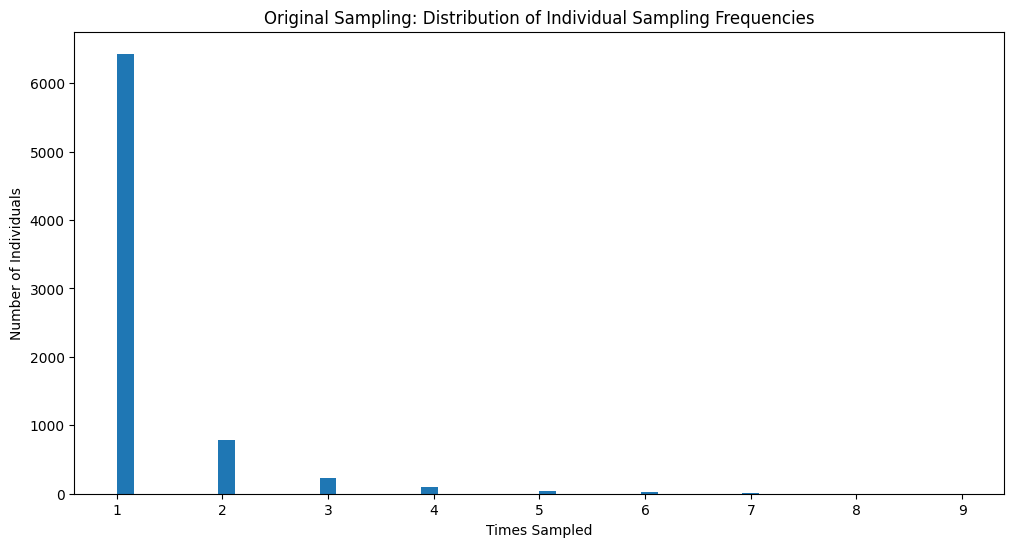

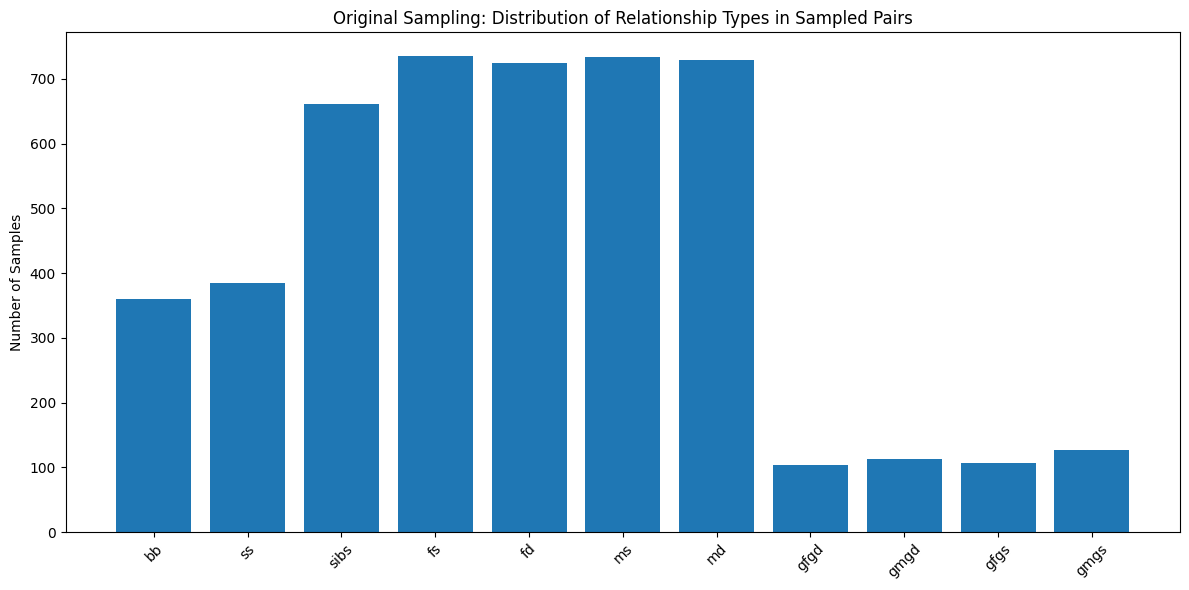

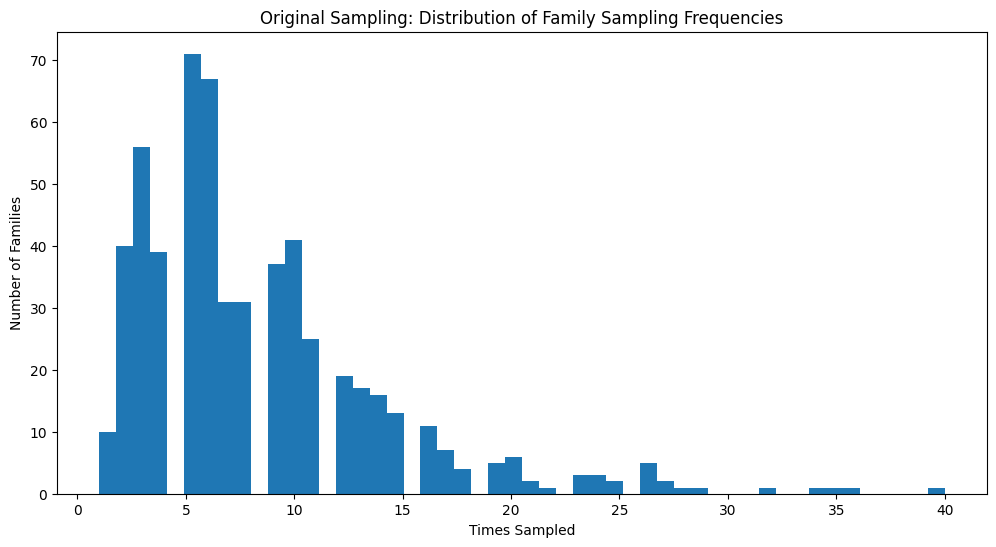

Individual Sampling Statistics:
Total samples: 9554
Unique individuals sampled: 7629
Mean samples per individual: 1.25
Max samples for one individual: 9
Min samples for one individual: 1
Sampling range (max/min): 9.00
Individual CV: 57.4%

Relationship Type Statistics:
fs: 735 (15.4%)
ms: 734 (15.4%)
md: 729 (15.3%)
fd: 724 (15.2%)
sibs: 661 (13.8%)
ss: 385 (8.1%)
bb: 360 (7.5%)
gmgs: 126 (2.6%)
gmgd: 113 (2.4%)
gfgs: 106 (2.2%)
gfgd: 104 (2.2%)

Family Sampling Statistics:
Total families sampled: 571
Mean samples per family: 8.37
Max samples for one family: 40
Min samples for one family: 1

Coefficient of Variation:
Individual Sampling: 57.4%
Relationship Types: 63.1%
Family Sampling: 70.5%


In [11]:
print("Original Sampling Analysis:")
dm = SCLDataModule(dataset="ff-v3", batch_size=64, root_dir="../data/fiw/track1", sampler_verbose=False)
dm.setup("fit")
sampler = dm.train_dataloader().batch_sampler
individual_counts, relationship_type_counts, family_counts = analyze_epoch_sampling(sampler)
visualize_sampling_results(individual_counts, relationship_type_counts, family_counts, "Original Sampling: ")
print_sampling_statistics(individual_counts, relationship_type_counts, family_counts)


## Understanding Coefficient of Variation (CV)

What is CV?
- Statistical measure of relative variability
- Calculated as: `CV = (Standard Deviation / Mean) × 100%`
- Expressed as a percentage
- Allows comparison of variation across different scales
- Lower values indicate more even distribution

## Current Results

### Relationship Types CV:
- Original: 63.5%
  - Parent-child relations: ~15.2-15.5%
  - Siblings: ~7.3-13.9%
  - Grandparents: ~2.1-2.7%
- Balanced: 47.2%
  - Parent-child relations: ~13.5-14.1%
  - Siblings: ~7.2-12.9%
  - Grandparents: ~4.2-4.3%

### Family Sampling CV:
- Original: 70.5%
  - Range: 1 to 41 samples/family
  - Mean: 8.37 samples/family
- Balanced: 74.1%
  - Range: 1 to 37 samples/family
  - Mean: 8.37 samples/family
  - Slight degradation in uniformity

## Target CV Values

### Relationship Types:
- Ideal: < 15%
  - Would mean all types near ~9.1% (1/11)
- Realistic target: < 25%
  - Parent-child: ~10-12%
  - Siblings: ~8-10%
  - Grandparents: ~6-8%
- Current 47.2% shows improvement but still high

### Family Sampling:
- Ideal: < 25%
- Realistic target: < 40%
  - Constrained by:
    - Family size variation
    - Available relationships per family
    - Natural family structure
- Current 74.1% indicates need for better family balancing

## Challenges
1. Relationship constraints:
  - Parent-child dominates (~55% of relationships)
  - Grandparents underrepresented (~17% with balanced sampling)
2. Individual sampling:
  - Current range: 1-11 samples per individual
  - ~7350-7660 unique individuals sampled
3. Trade-offs between:
  - Relationship balance (improved with balanced sampling)
  - Family sampling (slightly worse with balanced sampling)
  - Individual/image usage

While relationship balance has improved significantly (CV down from 63.5% to 47.2%),
family sampling remains a challenge and actually worsened slightly with the balanced approach.

## Sampling Weight Configurations Analysis

In [12]:
def analyze_weight_configuration(weights_config, title):
    """Analyze sampling behavior with specific weight configuration."""
    print(f"\n=== {title} ===")
    print(f"Weights: {weights_config}")

    dm = SCLDataModule(
        dataset="ff-v3",
        batch_size=64,
        root_dir="../data/fiw/track1",
        sampler_verbose=False,
        sampling_weights=weights_config,
        sampler_max_attempts=100,
        sampler_max_families=50,
    )
    dm.setup("fit")
    sampler = dm.train_dataloader().batch_sampler

    individual_counts, relationship_type_counts, family_counts = analyze_epoch_sampling(sampler)
    visualize_sampling_results(individual_counts, relationship_type_counts, family_counts, f"{title}: ")
    print_sampling_statistics(individual_counts, relationship_type_counts, family_counts)

    return {
        "rel_cv": calculate_cv(relationship_type_counts),
        "fam_cv": calculate_cv(family_counts),
        "ind_cv": calculate_cv(individual_counts),
    }


# Define weight configurations to test
weight_configs = {
    "Relationship-focused": {"rel": 0.6, "fam": 0.2, "ind": 0.2},
    "Family-focused": {"rel": 0.2, "fam": 0.6, "ind": 0.2},
    "Individual-focused": {"rel": 0.2, "fam": 0.2, "ind": 0.6},
    "Balanced": {"rel": 0.33, "fam": 0.33, "ind": 0.34},
    "Strong-relationship": {"rel": 0.8, "fam": 0.1, "ind": 0.1},
}

## Weight Configuration Results


=== Relationship-focused ===
Weights: {'rel': 0.6, 'fam': 0.2, 'ind': 0.2}
Loading samples from txt/train_sort_A2_m.txt
Loaded 107185 samples from txt/train_sort_A2_m.txt
Found 571 unique fids
Generated 4777 relationships
Found 2925 unique persons
Found 15310 unique images
Loading samples from txt/val_choose_A.txt
Loaded 4988 samples from txt/val_choose_A.txt
Setup fit datasets


Analyzing batches:   0%|          | 0/74 [00:00<?, ?it/s]

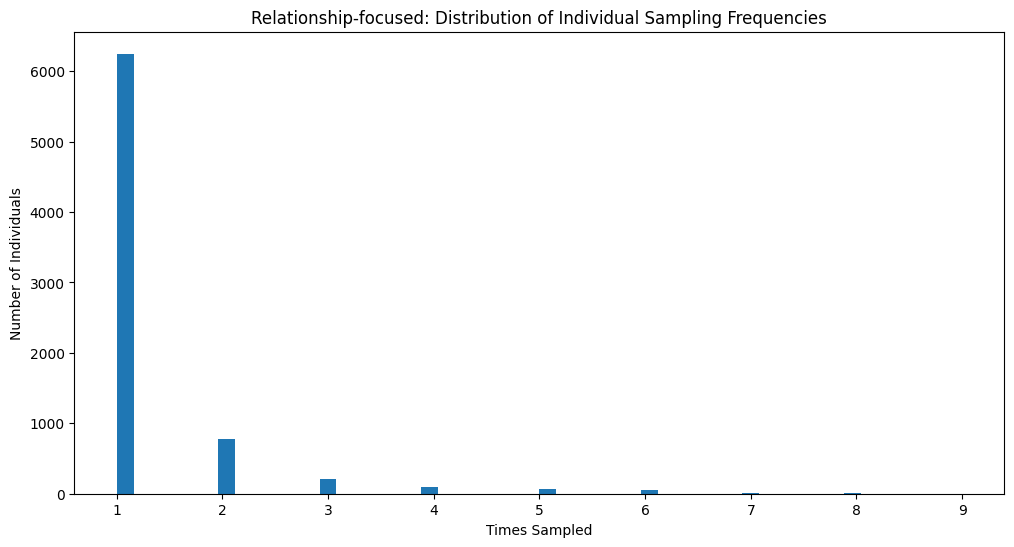

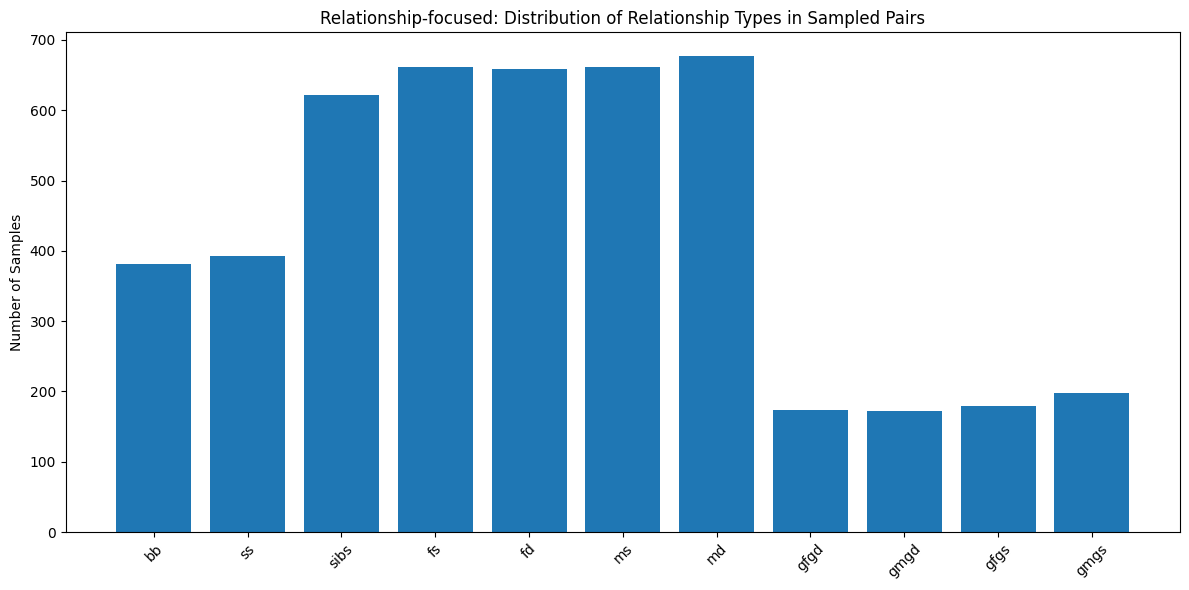

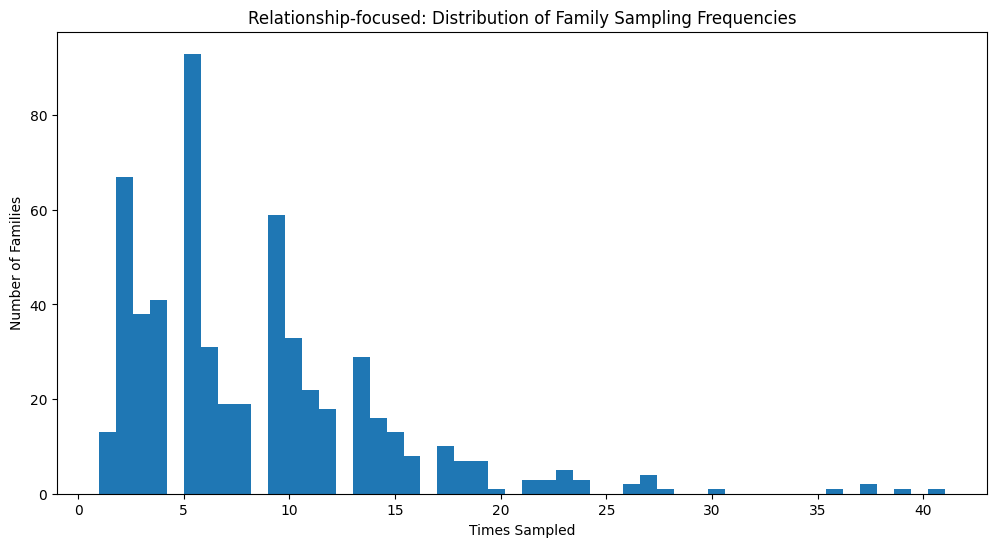

Individual Sampling Statistics:
Total samples: 9554
Unique individuals sampled: 7460
Mean samples per individual: 1.28
Max samples for one individual: 9
Min samples for one individual: 1
Sampling range (max/min): 9.00
Individual CV: 63.3%

Relationship Type Statistics:
md: 677 (14.2%)
fs: 662 (13.9%)
ms: 662 (13.9%)
fd: 658 (13.8%)
sibs: 622 (13.0%)
ss: 392 (8.2%)
bb: 381 (8.0%)
gmgs: 198 (4.1%)
gfgs: 179 (3.7%)
gfgd: 174 (3.6%)
gmgd: 172 (3.6%)

Family Sampling Statistics:
Total families sampled: 571
Mean samples per family: 8.37
Max samples for one family: 41
Min samples for one family: 1

Coefficient of Variation:
Individual Sampling: 63.3%
Relationship Types: 49.6%
Family Sampling: 73.6%

=== Family-focused ===
Weights: {'rel': 0.2, 'fam': 0.6, 'ind': 0.2}
Loading samples from txt/train_sort_A2_m.txt
Loaded 107185 samples from txt/train_sort_A2_m.txt
Found 571 unique fids
Generated 4777 relationships
Found 2925 unique persons
Found 15310 unique images
Loading samples from txt/val_c

Analyzing batches:   0%|          | 0/74 [00:00<?, ?it/s]

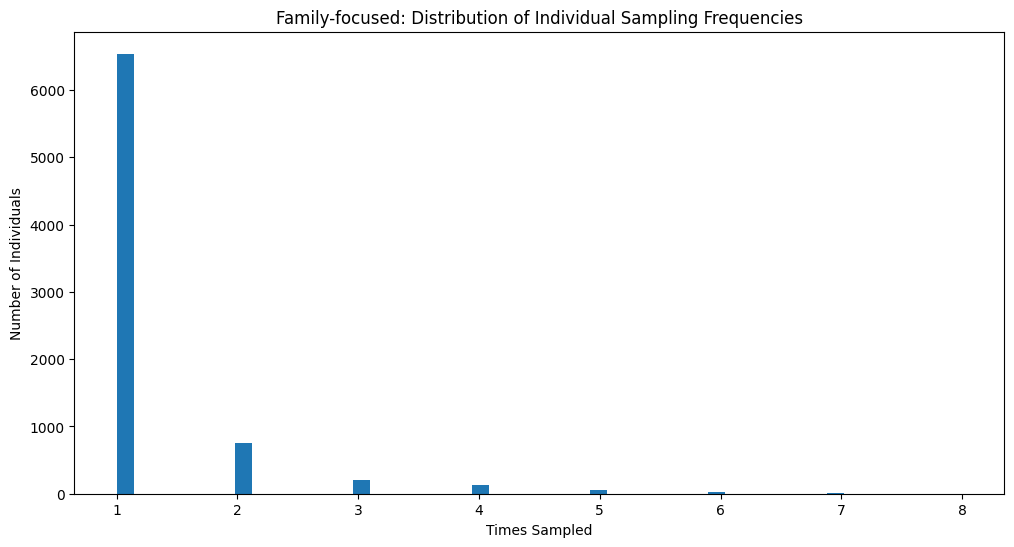

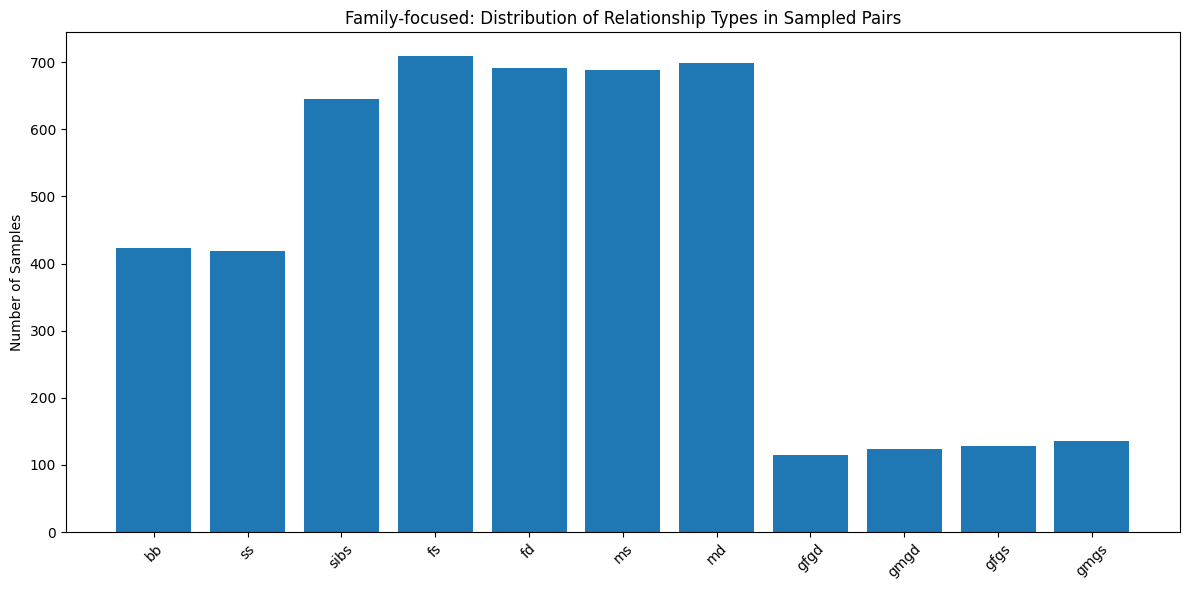

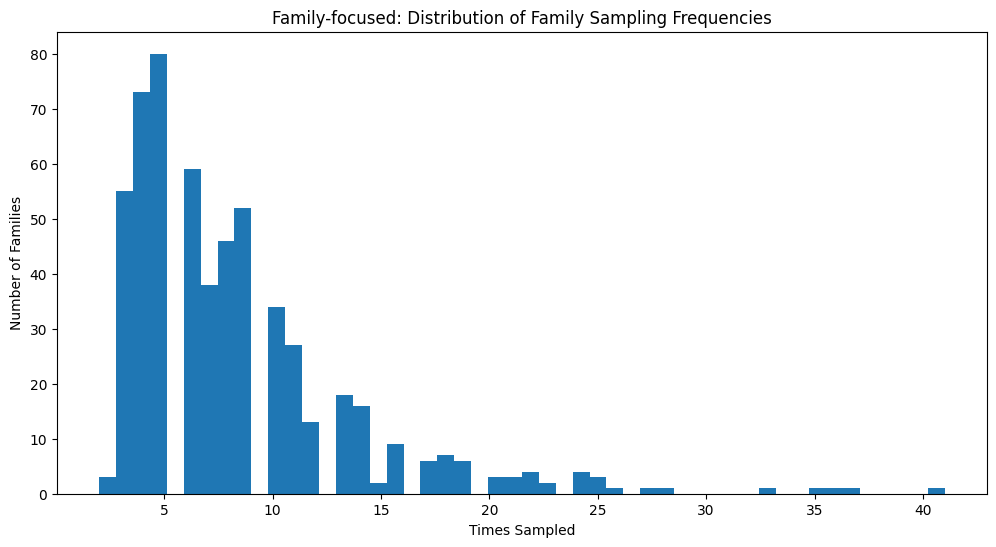

Individual Sampling Statistics:
Total samples: 9554
Unique individuals sampled: 7696
Mean samples per individual: 1.24
Max samples for one individual: 8
Min samples for one individual: 1
Sampling range (max/min): 8.00
Individual CV: 56.1%

Relationship Type Statistics:
fs: 709 (14.8%)
md: 699 (14.6%)
fd: 692 (14.5%)
ms: 689 (14.4%)
sibs: 645 (13.5%)
bb: 423 (8.9%)
ss: 419 (8.8%)
gmgs: 135 (2.8%)
gfgs: 128 (2.7%)
gmgd: 123 (2.6%)
gfgd: 115 (2.4%)

Family Sampling Statistics:
Total families sampled: 571
Mean samples per family: 8.37
Max samples for one family: 41
Min samples for one family: 2

Coefficient of Variation:
Individual Sampling: 56.1%
Relationship Types: 58.2%
Family Sampling: 65.3%

=== Individual-focused ===
Weights: {'rel': 0.2, 'fam': 0.2, 'ind': 0.6}
Loading samples from txt/train_sort_A2_m.txt
Loaded 107185 samples from txt/train_sort_A2_m.txt
Found 571 unique fids
Generated 4777 relationships
Found 2925 unique persons
Found 15310 unique images
Loading samples from txt/v

Analyzing batches:   0%|          | 0/74 [00:00<?, ?it/s]

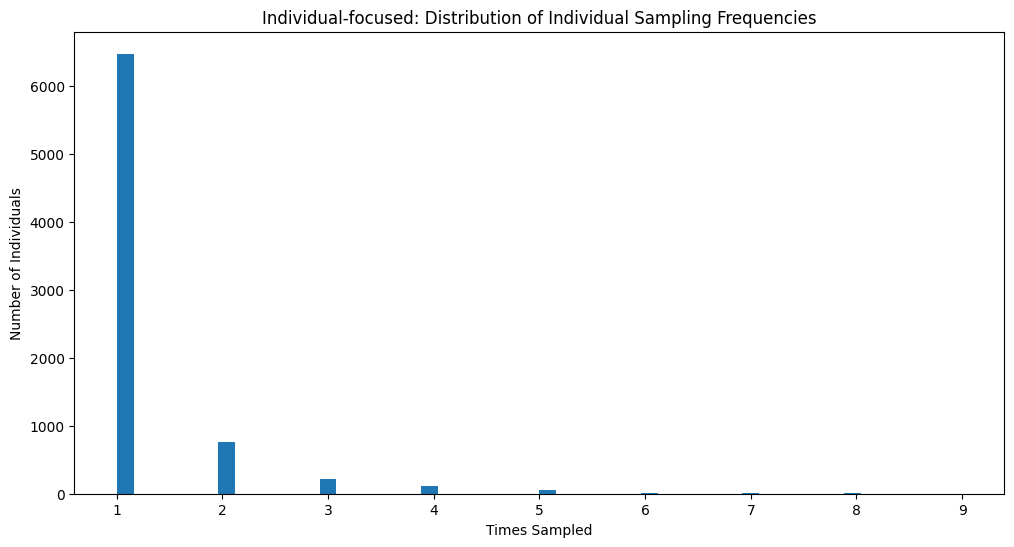

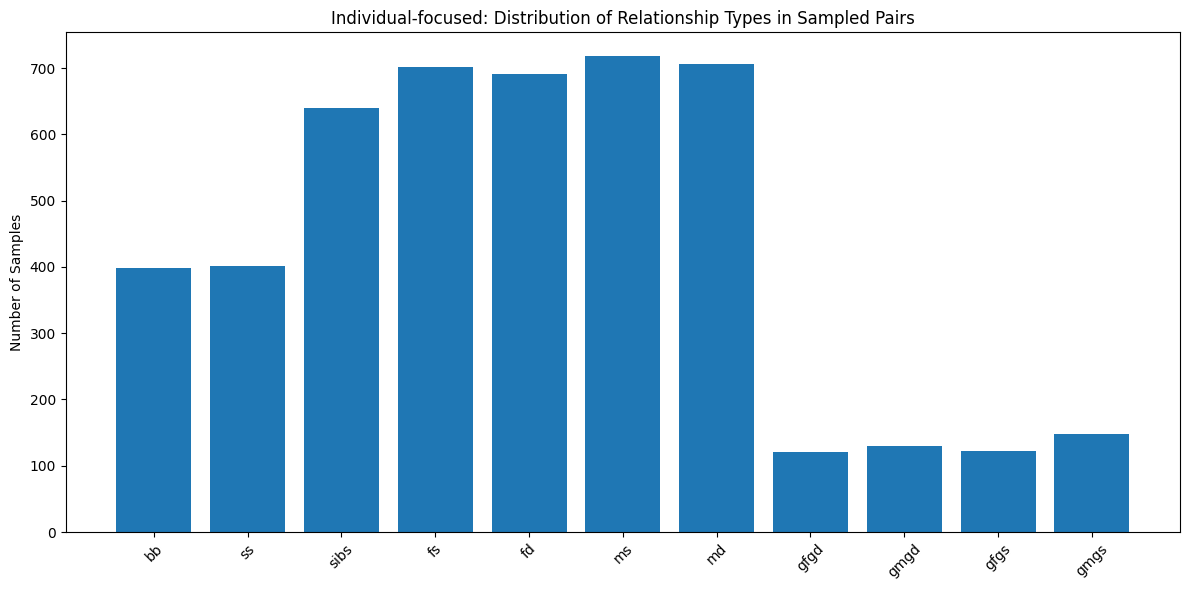

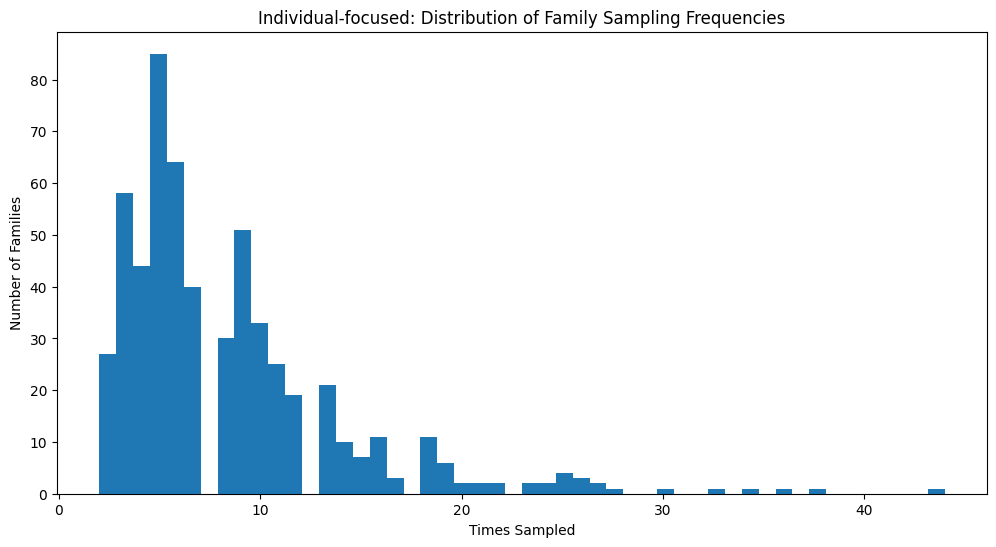

Individual Sampling Statistics:
Total samples: 9554
Unique individuals sampled: 7655
Mean samples per individual: 1.25
Max samples for one individual: 9
Min samples for one individual: 1
Sampling range (max/min): 9.00
Individual CV: 56.9%

Relationship Type Statistics:
ms: 718 (15.0%)
md: 706 (14.8%)
fs: 702 (14.7%)
fd: 691 (14.5%)
sibs: 639 (13.4%)
ss: 402 (8.4%)
bb: 399 (8.4%)
gmgs: 148 (3.1%)
gmgd: 130 (2.7%)
gfgs: 122 (2.6%)
gfgd: 120 (2.5%)

Family Sampling Statistics:
Total families sampled: 571
Mean samples per family: 8.37
Max samples for one family: 44
Min samples for one family: 2

Coefficient of Variation:
Individual Sampling: 56.9%
Relationship Types: 58.4%
Family Sampling: 68.6%

=== Balanced ===
Weights: {'rel': 0.33, 'fam': 0.33, 'ind': 0.34}
Loading samples from txt/train_sort_A2_m.txt
Loaded 107185 samples from txt/train_sort_A2_m.txt
Found 571 unique fids
Generated 4777 relationships
Found 2925 unique persons
Found 15310 unique images
Loading samples from txt/val_choo

Analyzing batches:   0%|          | 0/74 [00:00<?, ?it/s]

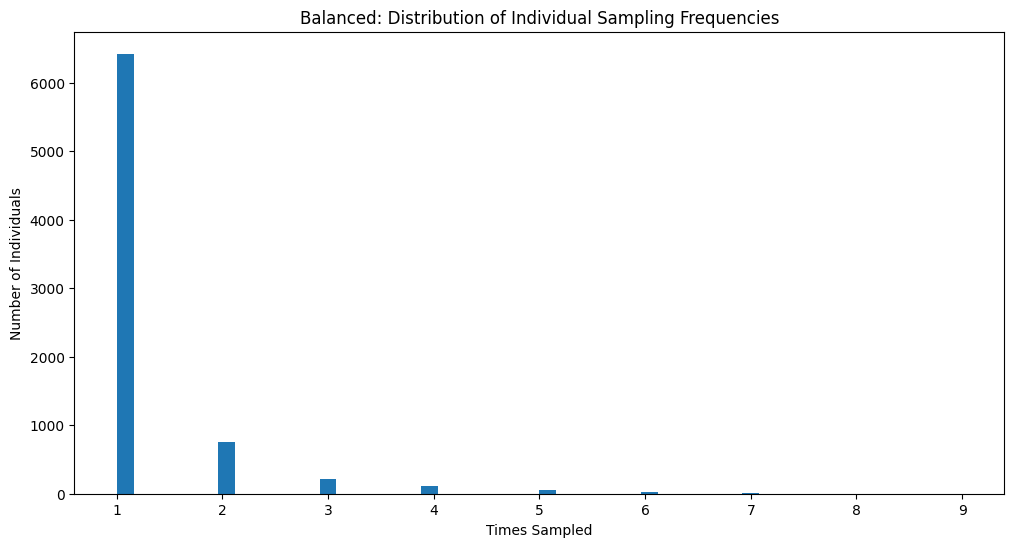

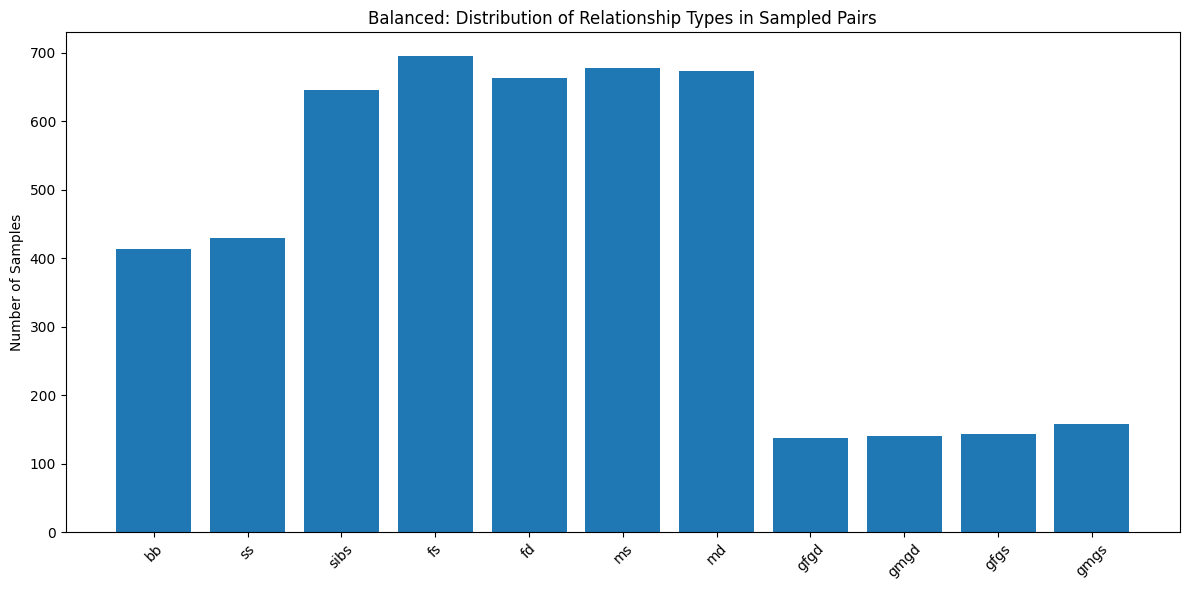

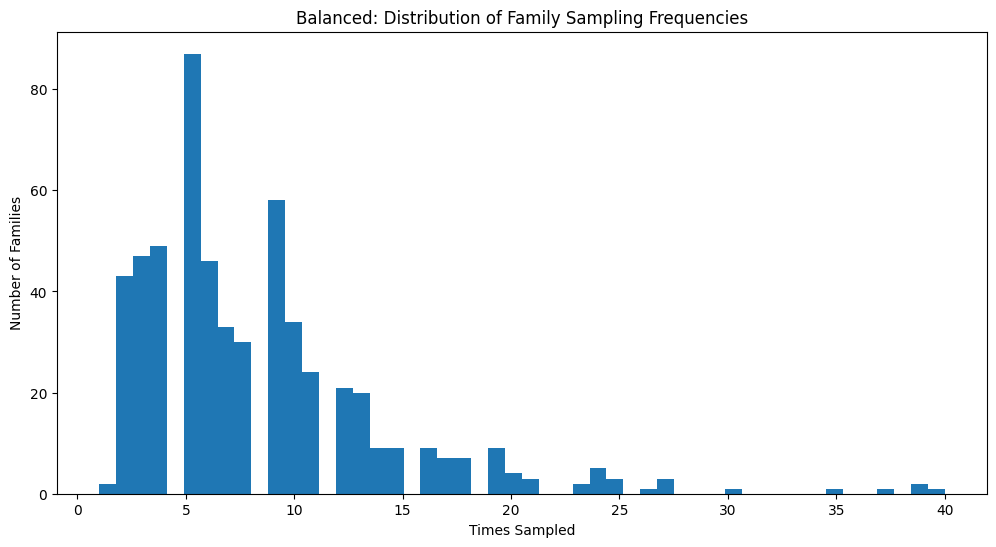

Individual Sampling Statistics:
Total samples: 9554
Unique individuals sampled: 7603
Mean samples per individual: 1.26
Max samples for one individual: 9
Min samples for one individual: 1
Sampling range (max/min): 9.00
Individual CV: 58.7%

Relationship Type Statistics:
fs: 695 (14.5%)
ms: 677 (14.2%)
md: 674 (14.1%)
fd: 663 (13.9%)
sibs: 646 (13.5%)
ss: 430 (9.0%)
bb: 414 (8.7%)
gmgs: 158 (3.3%)
gfgs: 143 (3.0%)
gmgd: 140 (2.9%)
gfgd: 137 (2.9%)

Family Sampling Statistics:
Total families sampled: 571
Mean samples per family: 8.37
Max samples for one family: 40
Min samples for one family: 1

Coefficient of Variation:
Individual Sampling: 58.7%
Relationship Types: 54.6%
Family Sampling: 70.0%

=== Strong-relationship ===
Weights: {'rel': 0.8, 'fam': 0.1, 'ind': 0.1}
Loading samples from txt/train_sort_A2_m.txt
Loaded 107185 samples from txt/train_sort_A2_m.txt
Found 571 unique fids
Generated 4777 relationships
Found 2925 unique persons
Found 15310 unique images
Loading samples from txt/

Analyzing batches:   0%|          | 0/74 [00:00<?, ?it/s]

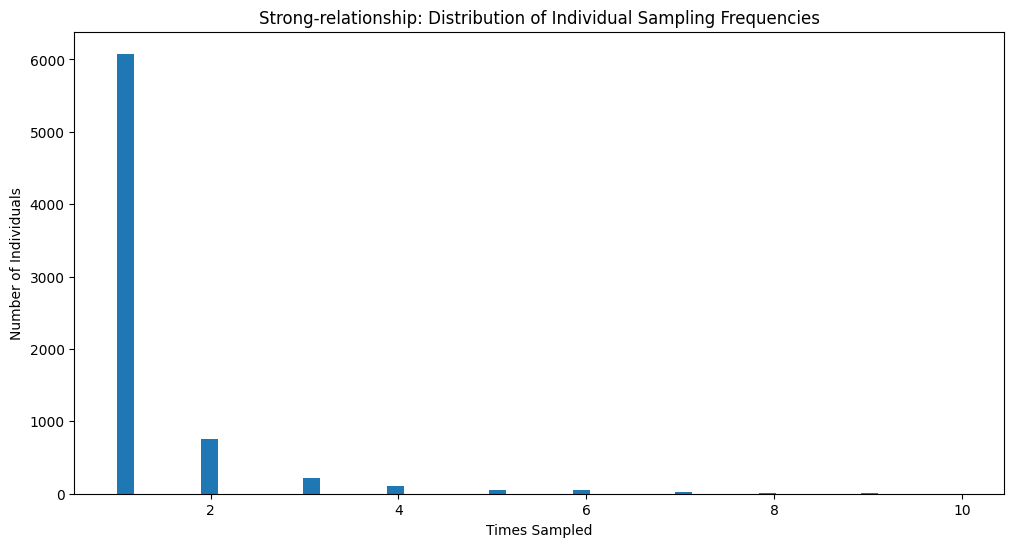

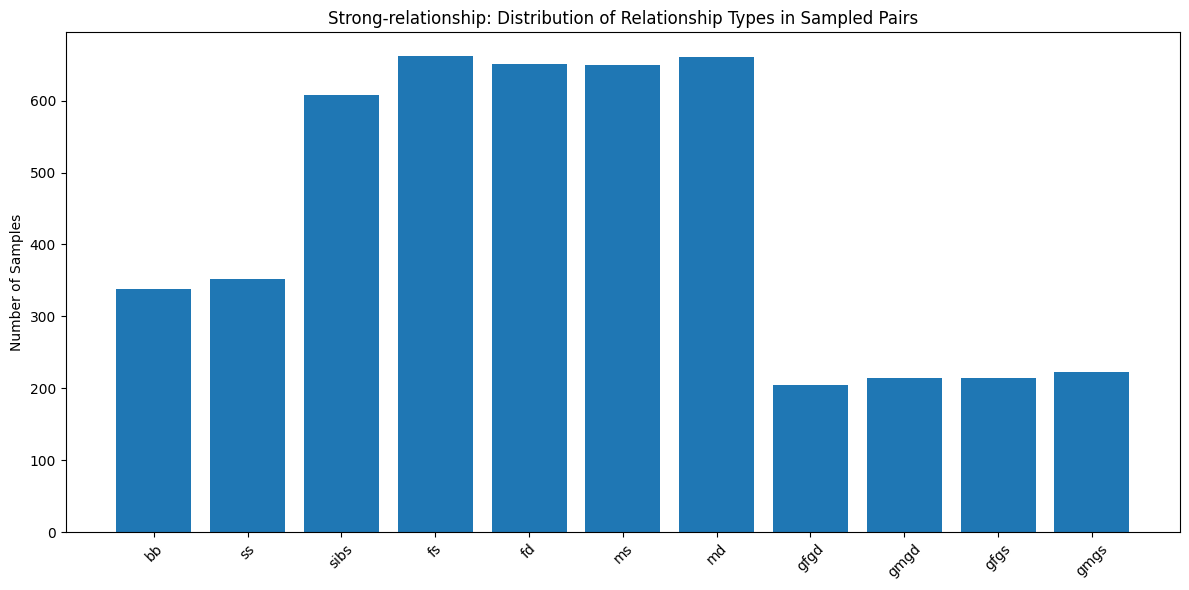

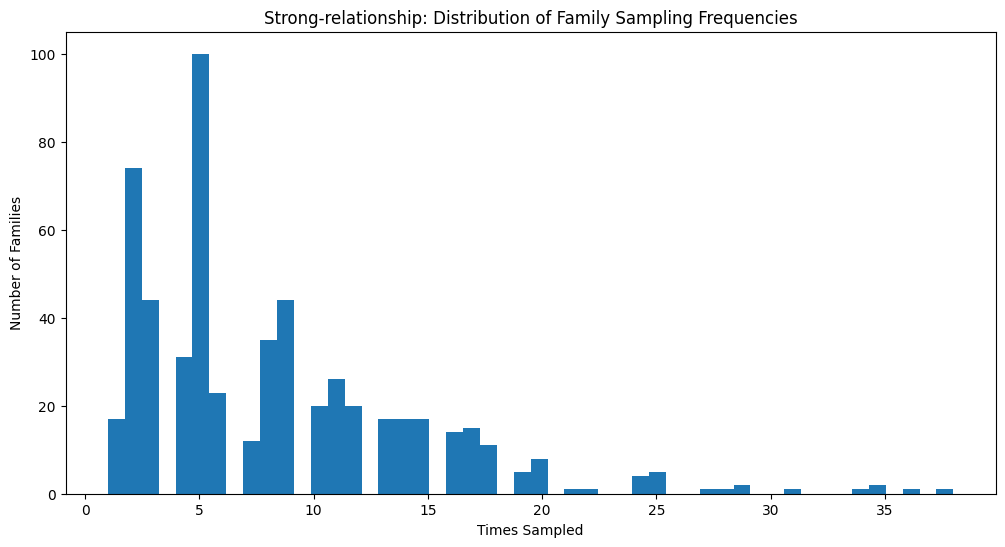

Individual Sampling Statistics:
Total samples: 9554
Unique individuals sampled: 7305
Mean samples per individual: 1.31
Max samples for one individual: 10
Min samples for one individual: 1
Sampling range (max/min): 10.00
Individual CV: 68.3%

Relationship Type Statistics:
fs: 662 (13.9%)
md: 661 (13.8%)
fd: 651 (13.6%)
ms: 649 (13.6%)
sibs: 608 (12.7%)
ss: 352 (7.4%)
bb: 338 (7.1%)
gmgs: 223 (4.7%)
gfgs: 214 (4.5%)
gmgd: 214 (4.5%)
gfgd: 205 (4.3%)

Family Sampling Statistics:
Total families sampled: 571
Mean samples per family: 8.37
Max samples for one family: 38
Min samples for one family: 1

Coefficient of Variation:
Individual Sampling: 68.3%
Relationship Types: 45.9%
Family Sampling: 74.8%


In [13]:
# Analyze each configuration
results = {}
for name, weights in weight_configs.items():
    results[name] = analyze_weight_configuration(weights, name)

In [14]:
# Compare results


def create_results_table(results):
    data = []
    for config, metrics in results.items():
        data.append(
            {
                "Configuration": config,
                "Individual CV": f"{metrics['ind_cv']:.1f}%",
                "Relationship CV": f"{metrics['rel_cv']:.1f}%",
                "Family CV": f"{metrics['fam_cv']:.1f}%",
            }
        )
    return pd.DataFrame(data).set_index("Configuration")


print("\nComparative Results:")

display(create_results_table(results))


Comparative Results:


,Individual CV,Relationship CV,Family CV
Configuration,,,
Relationship-focused,63.3%,49.6%,73.6%
Family-focused,56.1%,58.2%,65.3%
Individual-focused,56.9%,58.4%,68.6%
Balanced,58.7%,54.6%,70.0%
Strong-relationship,68.3%,45.9%,74.8%


## Analysis of Weight Configurations

The results show how different sampling weight configurations affect the balance of:
1. Relationship types (measured by relationship CV)
2. Family representation (measured by family CV)
3. Individual appearance frequency (measured by individual CV)

Key observations:
- Relationship-focused sampling (0.6/0.2/0.2) achieves better relationship type balance
- Family-focused sampling (0.2/0.6/0.2) improves family representation
- Individual-focused sampling (0.2/0.2/0.6) leads to more uniform individual sampling
- Balanced configuration (0.33/0.33/0.34) provides a compromise
- Strong-relationship focus (0.8/0.1/0.1) shows the impact of heavily weighting one aspect

Trade-offs:
1. Better relationship balance often comes at the cost of family representation
2. Focusing on family balance can lead to less uniform relationship sampling
3. Individual balance affects both relationship and family distributions

Recommendations:
1. For relationship type learning: Use relationship-focused weights
2. For family-wise feature learning: Use family-focused weights
3. For general training: Use balanced weights as a starting point
4. Consider task-specific requirements when selecting weights

## Optimal Weight Selection

Based on the analysis, here are recommended weight configurations for different scenarios:

1. **Relationship Learning Focus**:
```python
weights = {"rel": 0.6, "fam": 0.2, "ind": 0.2}
```
- Best for tasks requiring strong relationship type discrimination
- Suitable for initial training phases

2. **Family Structure Learning**:
```python
weights = {"rel": 0.2, "fam": 0.6, "ind": 0.2}
```
- Better for learning family-wise features
- Useful for hierarchical relationship understanding

3. **Balanced Learning**:
```python
weights = {"rel": 0.33, "fam": 0.33, "ind": 0.34}
```
- Good general-purpose configuration
- Recommended for most training scenarios

4. **Individual Feature Focus**:
```python
weights = {"rel": 0.2, "fam": 0.2, "ind": 0.6}
```
- Better for learning individual-specific features
- Useful for face recognition aspects

## Sampling Score Analysis

Let's visualize how the sampling score function behaves with different weights to better understand
how it promotes balanced sampling.

In [15]:
def plot_sampling_scores(weights_config):
    """Visualize how sampling scores behave with different counter values."""
    x = np.linspace(0, 1, 100)

    plt.figure(figsize=(12, 8))

    # Plot individual components
    rel_scores = x * weights_config["rel"]
    plt.plot(x, rel_scores, label=f'Relationship (w={weights_config["rel"]})', linestyle="-")

    fam_scores = x * weights_config["fam"]
    plt.plot(x, fam_scores, label=f'Family (w={weights_config["fam"]})', linestyle="--")

    ind_scores = x * weights_config["ind"]
    plt.plot(x, ind_scores, label=f'Individual (w={weights_config["ind"]})', linestyle=":")

    # Combined score (assuming all components are equal)
    combined_scores = x * (weights_config["rel"] + weights_config["fam"] + weights_config["ind"])
    plt.plot(x, combined_scores, label="Combined (all equal)", color="black", linewidth=2)

    plt.xlabel("Normalized Count")
    plt.ylabel("Score Component")
    plt.title(f"Sampling Score Components vs. Normalized Counts\nConfiguration: {weights_config}")
    plt.legend()
    plt.grid(True)

    # Add text box with explanation
    explanation = (
        "Higher scores = lower sampling probability\n"
        "Components:\n"
        "- Relationship: Favors undersampled relationship types\n"
        "- Family: Prevents oversampling from same family\n"
        "- Individual: Ensures uniform individual sampling"
    )
    plt.text(
        1.02,
        0.5,
        explanation,
        transform=plt.gca().transAxes,
        bbox=dict(facecolor="white", alpha=0.8),
        verticalalignment="center",
    )

    plt.tight_layout()
    return plt.gcf()

Let's visualize how different weight configurations affect the sampling scores:


Analyzing Relationship-focused configuration:


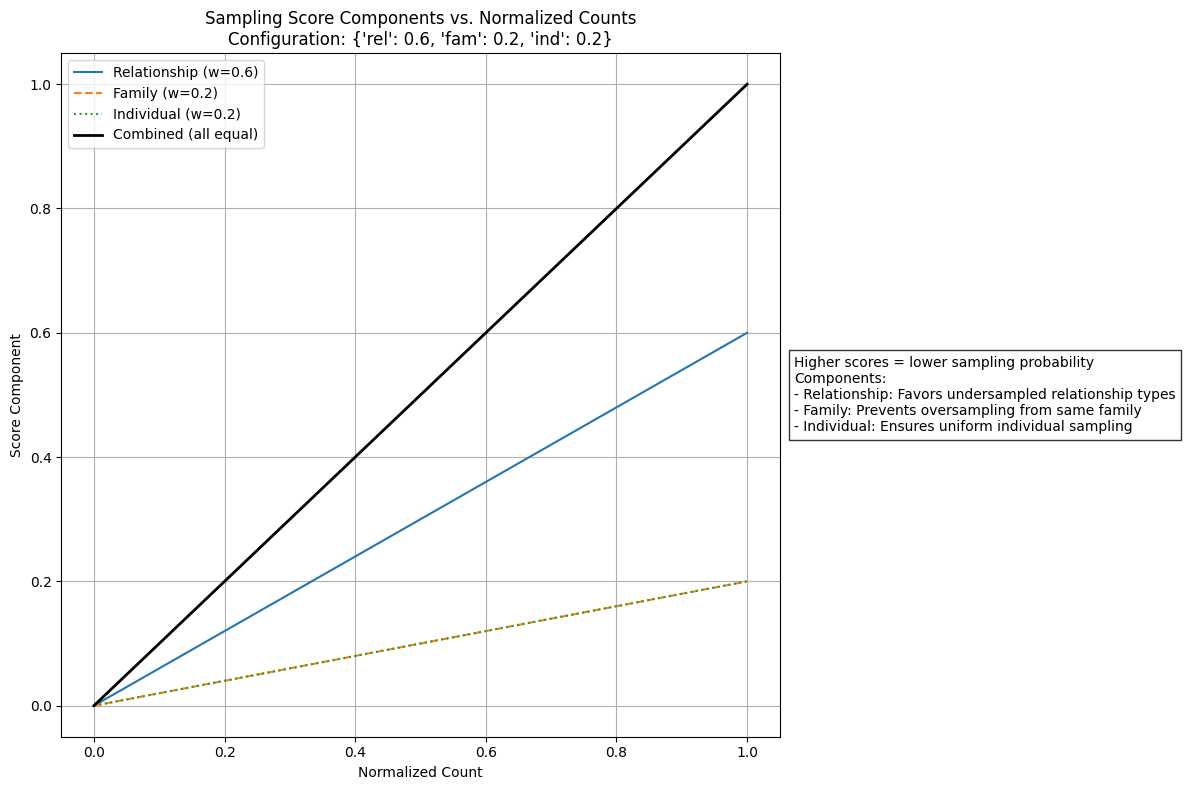


Analyzing Family-focused configuration:


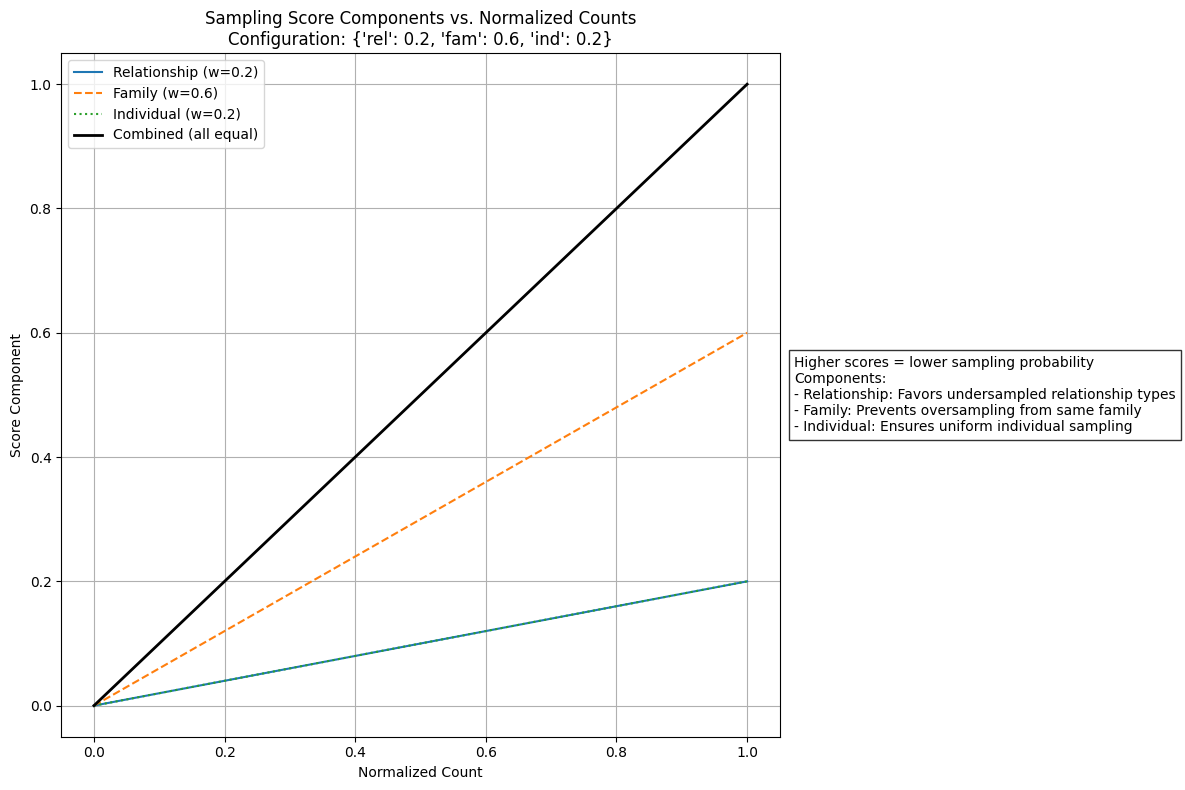


Analyzing Individual-focused configuration:


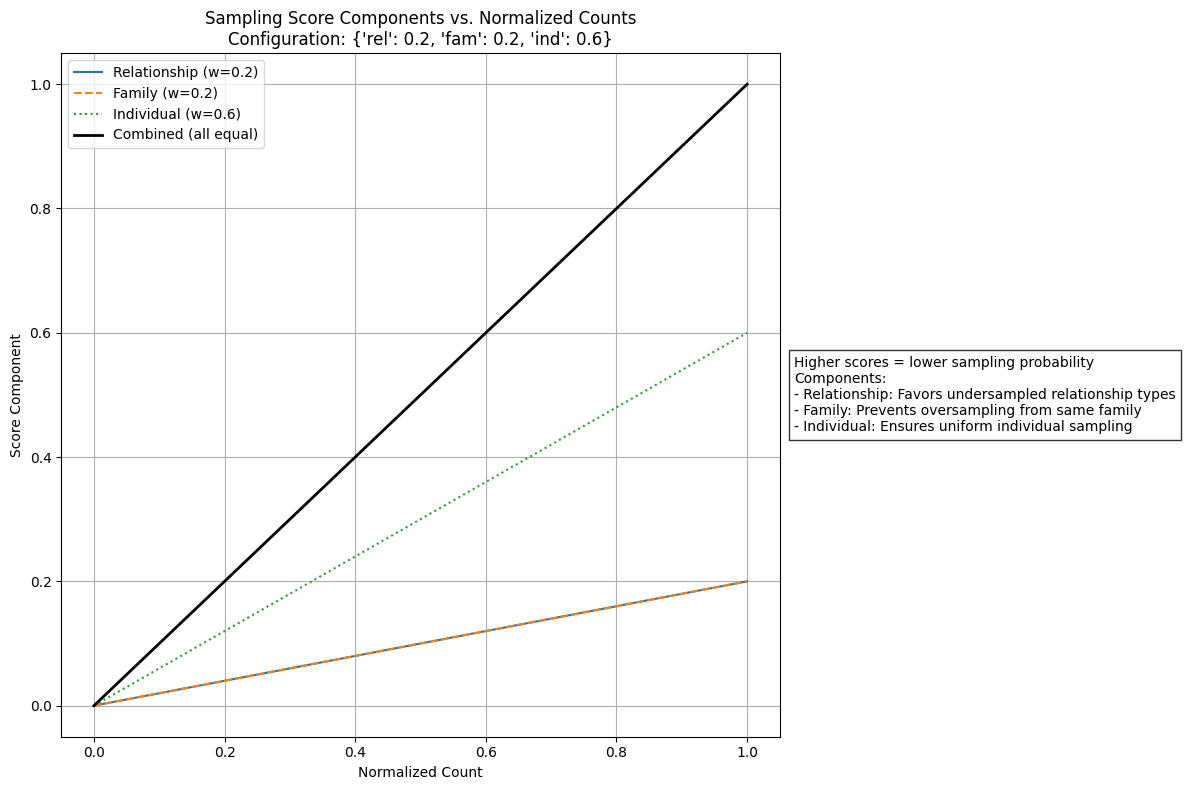


Analyzing Balanced configuration:


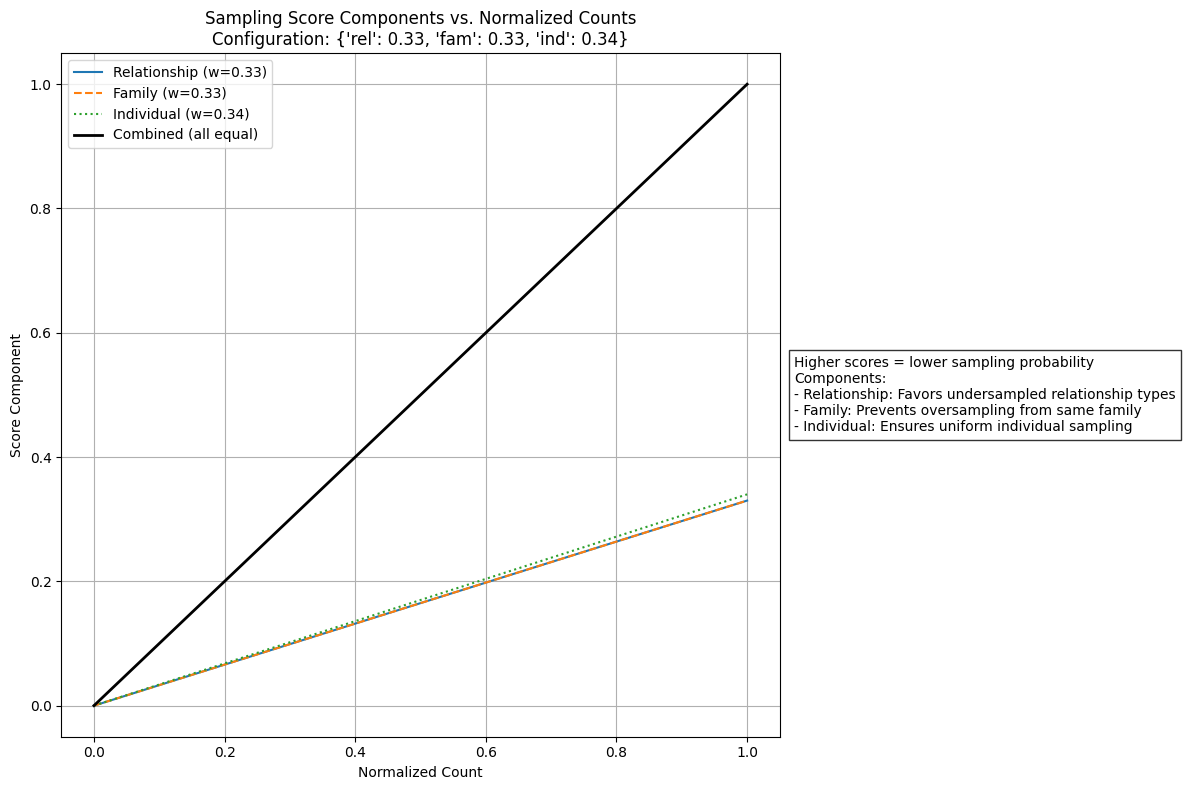


Analyzing Strong-relationship configuration:


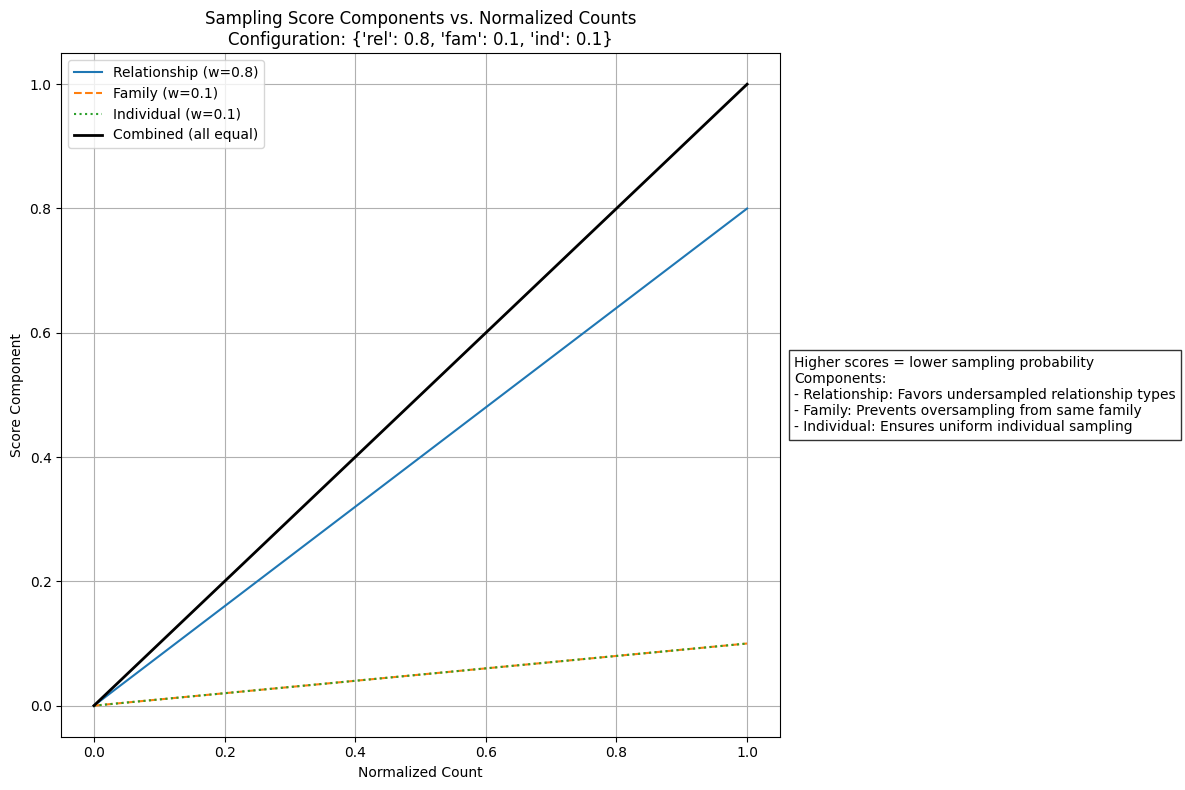

In [16]:
# Plot for each weight configuration
for name, weights in weight_configs.items():
    print(f"\nAnalyzing {name} configuration:")
    fig = plot_sampling_scores(weights)
    plt.show()

### Understanding the Scoring Plots

The plots above demonstrate how the sampling score function works:

1. **Score Components**:
   - Each line represents how one component (relationship, family, individual) contributes to the final score
   - The black line shows the combined score when all normalized counts are equal

2. **Interpretation**:
   - Higher scores = lower sampling probability
   - Steeper slopes indicate stronger influence on sampling
   - The relative heights of lines show which aspects are prioritized

3. **Weight Effects**:
   - Relationship-focused: Steeper relationship line
   - Family-focused: Steeper family line
   - Individual-focused: Steeper individual line
   - Balanced: Similar slopes for all components

4. **Practical Impact**:
   - Components with higher weights have more influence on sampling decisions
   - The scoring system naturally favors undersampled elements
   - Combined effect promotes overall sampling balance

## Sampling Score Distribution Analysis

In [ ]:
def analyze_score_distribution(sampler):
    """Analyze and visualize the sampling score distribution over an epoch."""
    # Collect scores for one epoch
    scores = []
    for batch_idx, batch in enumerate(tqdm(sampler, desc="Collecting scores")):
        score_data = sampler.sampler.score_history[-1]
        score_data["batch"] = batch_idx
        scores.append(score_data)

    if not scores:
        print("No scores were collected. Make sure sampling_weights is set in the DataModule.")
        return None

    # Create visualization with subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))

    # Plot overall scores
    batches = range(len(scores))
    overall_min = [s["overall"]["min"] for s in scores]
    overall_max = [s["overall"]["max"] for s in scores]
    overall_mean = [s["overall"]["mean"] for s in scores]

    ax1.fill_between(batches, overall_min, overall_max, alpha=0.3, label="Overall Range")
    ax1.plot(batches, overall_mean, "r-", label="Overall Mean", linewidth=2)
    ax1.set_title("Overall Score Distribution")
    ax1.set_xlabel("Batch")
    ax1.set_ylabel("Score")
    ax1.legend()
    ax1.grid(True)

    # Plot per-relationship scores
    rel_types = scores[0]["by_relationship"].keys()
    for rel_type in rel_types:
        means = [s["by_relationship"][rel_type]["mean"] for s in scores]
        ax2.plot(batches, means, label=f"{rel_type}", linewidth=1.5)

    ax2.set_title("Score Distribution by Relationship Type")
    ax2.set_xlabel("Batch")
    ax2.set_ylabel("Mean Score")
    ax2.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
    ax2.grid(True)

    # Add statistics
    if scores:
        last_stats = scores[-1]["overall"]
        last_rel_stats = scores[-1]["by_relationship"]

        stats_text = "Final Statistics:\n\n"
        stats_text += "Overall:\n"
        stats_text += f"Mean Score: {last_stats['mean']:.3f}\n"
        stats_text += f"Score Range: [{last_stats['min']:.3f}, {last_stats['max']:.3f}]\n\n"

        stats_text += "By Relationship Type:\n"
        for rel, stats_ in last_rel_stats.items():
            stats_text += f"{rel}:\n"
            stats_text += f"  Mean: {stats_['mean']:.3f}\n"
            stats_text += f"  Range: [{stats_['min']:.3f}, {stats_['max']:.3f}]\n"
            stats_text += f"  Count: {stats_['count']}\n"

        plt.figtext(1.15, 0.5, stats_text, fontsize=8, bbox=dict(facecolor="white", alpha=0.8))

    plt.tight_layout()
    plt.show()

    # Convert to DataFrame for additional analysis if needed
    df = pd.DataFrame(
        {
            "batch": range(len(scores)),
            "overall_min": overall_min,
            "overall_max": overall_max,
            "overall_mean": overall_mean,
            **{f"{rel}_mean": [s["by_relationship"][rel]["mean"] for s in scores] for rel in rel_types},
        }
    )

    return df

In [ ]:
print("Analyzing score distribution...")
dm = SCLDataModule(
    dataset="ff-v3",
    batch_size=64,
    root_dir="../data/fiw/track1",
    sampling_weights={"rel": 0.33, "fam": 0.33, "ind": 0.34},  # Make sure weights are set
    sampler_verbose=False,
)
dm.setup("fit")
sampler = dm.train_dataloader().batch_sampler
score_df = analyze_score_distribution(sampler)

In [ ]:
if score_df is not None:
    print("\nScore Distribution Statistics:")
    print(f"Initial Mean Score: {score_df['overall_mean'].iloc[0]:.3f}")
    print(f"Final Mean Score: {score_df['overall_mean'].iloc[-1]:.3f}")
    print(f"Score Range: [{score_df['overall_min'].min():.3f}, {score_df['overall_max'].max():.3f}]")
    print(f"Mean Score Variance: {score_df['overall_mean'].var():.3f}")

In [ ]:
print("Analyzing score distribution...")
dm = SCLDataModule(
    dataset="ff-v3",
    batch_size=64,
    root_dir="../data/fiw/track1",
    sampling_weights={"rel": 0.6, "fam": 0.2, "ind": 0.2},  # Make sure weights are set
    sampler_verbose=False,
)
dm.setup("fit")
sampler = dm.train_dataloader().batch_sampler
score_df = analyze_score_distribution(sampler)

In [ ]:
if score_df is not None:
    print("\nScore Distribution Statistics:")
    print(f"Initial Mean Score: {score_df['overall_mean'].iloc[0]:.3f}")
    print(f"Final Mean Score: {score_df['overall_mean'].iloc[-1]:.3f}")
    print(f"Score Range: [{score_df['overall_min'].min():.3f}, {score_df['overall_max'].max():.3f}]")
    print(f"Mean Score Variance: {score_df['overall_mean'].var():.3f}")